In [1]:
from pyhdf.SD import SD
import netCDF4
import shapely
import shapely.geometry
import geopandas
import numpy
import sqlalchemy

In [2]:
class VIIRS:
    def __init__(self, fname):
        self.data = netCDF4.Dataset(fname, 'r', format='NETCDF4')
    
    def load_latlon(self):
        self.lat = self.data['geolocation_data']['latitude'][:].data
        self.lon = self.data['geolocation_data']['longitude'][:].data
    
    def outline(self):
        return shapely.geometry.Polygon([
                            (self.lon[0][0], self.lat[0][0]),
                            (self.lon[0][-1], self.lat[0][-1]),
                            (self.lon[-1][-1], self.lat[-1][-1]),
                            (self.lon[-1][0], self.lat[-1][0])])
    
    def as_df(self):
        self.df = geopandas.GeoDataFrame({'lat': self.lat.flatten(), 'lon': self.lon.flatten()}) 
    
    def as_gdf(self):
        self.gdf = self.df
        self.gdf['geometry'] = geopandas.points_from_xy(self.lon.flatten(), self.lat.flatten())
        self.gdf.set_geometry('geometry', inplace=True)
    
    def to_gpkg(self, name):
        self.gdf.to_file(name, driver='GPKG')
        
    def to_sqlite(self, name):        
        engine = sqlalchemy.create_engine('sqlite:///{}'.format(name), echo=False)
        self.df.to_sql(name, con=engine)
        
    
class MODIS(VIIRS):
    def __init__(self, fname):
        self.data = SD(fname)
        
    def load_latlon(self):
        self.lat = self.data.select('Latitude').get()
        self.lon = self.data.select('Longitude').get()

In [6]:
mod = MODIS('data/MOD09.A2020032.1940.006.2020034015024.hdf')

mod.load_latlon()
mod.as_df()

In [11]:
# "there are typically 203 full scans ..." -> 1354/first dimension is in scan direction

import numpy, pandas, math, nvector
latdiff = numpy.diff(mod.lat, n=1)
londiff = numpy.diff(mod.lon, n=1)

x = numpy.cos(mod.lon/360*math.pi*2) * numpy.cos(mod.lat/360*math.pi*2)
y = numpy.sin(mod.lon/360*math.pi*2) * numpy.cos(mod.lat/360*math.pi*2)
z = numpy.sin(mod.lat/360*math.pi*2)

ecef_pos = numpy.array([x, y, z]).transpose()
ecef_diff = numpy.append(numpy.diff(ecef_pos, axis=0), numpy.zeros((1,2030, 3)), axis=0)
ecef_mid = ecef_pos+ecef_diff/2

symetry_axis = numpy.cross(ecef_pos, ecef_mid, axis=-1)
norm = numpy.linalg.norm(symetry_axis, axis=-1, keepdims=True)
symetry_axis = numpy.true_divide(symetry_axis, norm, out=numpy.zeros_like(symetry_axis), where=norm!=0)

base_axis = numpy.cross(symetry_axis, ecef_mid, axis=-1)


# NG: Now all we need to do is move in the direction of 
# the vector of the great citcle of the symetry axis from the points
# We do this by creating the R3 rotation matrix (https://en.wikipedia.org/wiki/Rotation_matrix)
# The rotation of a vector {\displaystyle \mathbf {x} }\mathbf {x}  
# around the axis {\displaystyle \mathbf {u} }\mathbf {u}  
# by an angle {\displaystyle \theta }\theta  can be written as:
#r =   base_axis  * (numpy.dot(base_axis, ecef_mid)) 
#    + cos(theta) * numpy.cross(numpy.cross(base_axis, ecef_mid)), base_axis)
#    + sin(theta) * numpy.cross(base_axis, ecef_mid)

In [12]:
ecef_diff

array([[[ 4.27007675e-04, -6.27279282e-04, -2.13980675e-05],
        [ 4.27722931e-04, -6.27070665e-04, -2.06232071e-05],
        [ 4.28080559e-04, -6.26415014e-04, -1.99079514e-05],
        ...,
        [ 3.94105911e-04, -6.40869141e-04, -5.30481339e-05],
        [ 3.94523144e-04, -6.40511513e-04, -5.21242619e-05],
        [ 3.94940376e-04, -6.40511513e-04, -5.12897968e-05]],

       [[ 4.24146652e-04, -6.22361898e-04, -2.16960907e-05],
        [ 4.24444675e-04, -6.21736050e-04, -2.09808350e-05],
        [ 4.25100327e-04, -6.21497631e-04, -2.02059746e-05],
        ...,
        [ 3.91840935e-04, -6.35862350e-04, -5.28693199e-05],
        [ 3.92019749e-04, -6.35623932e-04, -5.20050526e-05],
        [ 3.92317772e-04, -6.35325909e-04, -5.10513783e-05]],

       [[ 4.20987606e-04, -6.16937876e-04, -2.18153000e-05],
        [ 4.21464443e-04, -6.16610050e-04, -2.11596489e-05],
        [ 4.22120094e-04, -6.16252422e-04, -2.03847885e-05],
        ...,
        [ 3.88979912e-04, -6.30497932e-04,

<IPython.core.display.Javascript object>


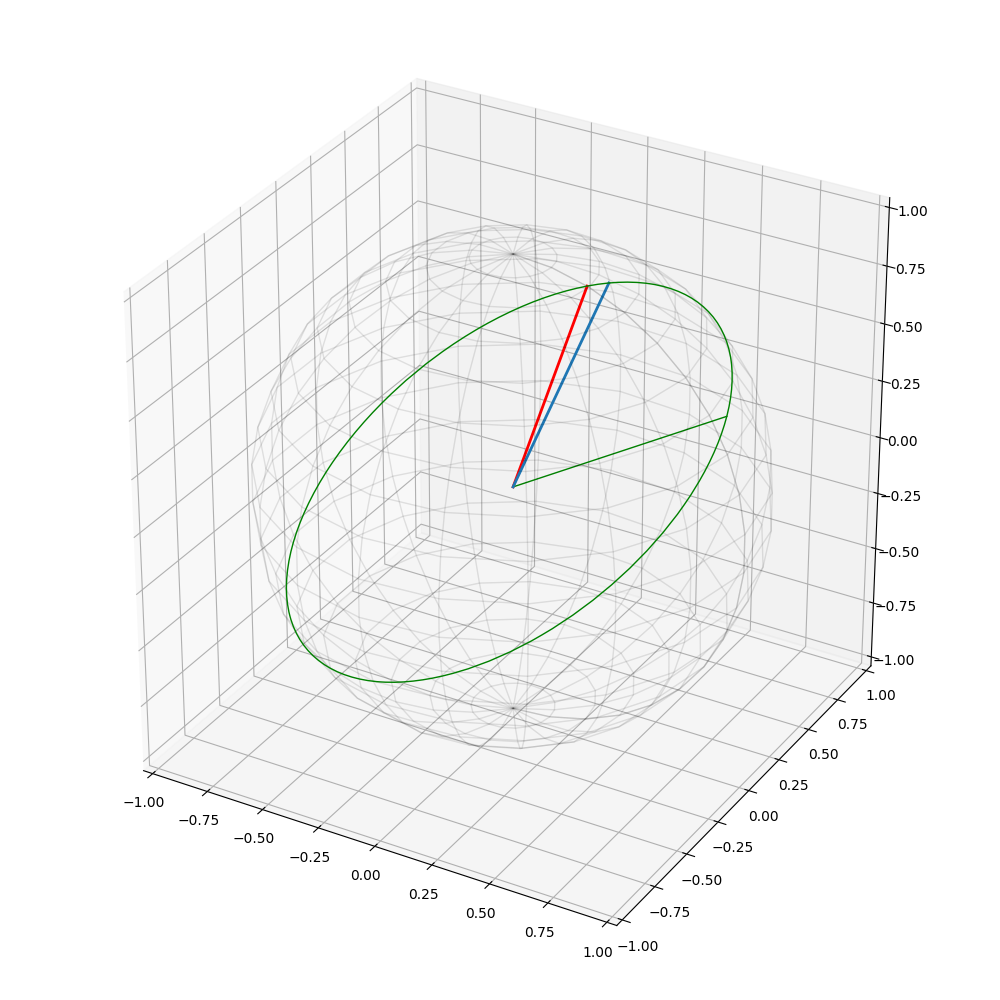

In [13]:
# Rotating shit

%matplotlib notebook
import plots, numpy

plot = plots.SpherePlot(radius=1)
def rotate(point, axis, angle):
    r =   axis  * (numpy.dot(axis, point)) \
        + numpy.cos(angle) * numpy.cross(numpy.cross(axis, point), axis) \
        + numpy.sin(angle) * numpy.cross(axis, point)    
    return r

point1 = numpy.array([1,0,3])
point2 = numpy.array([1,2,0])

axis = numpy.cross(point1, point2)
angle = numpy.pi/5

point3 = rotate(point1, axis, angle)
plot.plot_nvector(point1, color='red',  linewidth=2)
plot.plot_nvector(point2, color='green')
plot.plot_nvector(point3, linewidth=2)
plot.plot_great_circle(axis=axis, radius=1, fill=False, edgecolor='green')

plot.make_sphere(wire=True, only_north=False, zoom=1, alpha=0.1)

In [14]:
distance = 1 # km
radians = 1 / 6371
numpy.cos(radians)

0.999999987681586

In [15]:
n = 0
df = pandas.DataFrame({
                  'lat': mod.lat[n], 
                  'lon': mod.lon[n], 
                  'x': ecef_pos[:, n, 0],
                  'y': ecef_pos[:, n, 1],
                  'z': ecef_pos[:, n, 2],
                  'x_next': ecef_mid[:, n, 0],
                  'y_next': ecef_mid[:, n, 1],
                  'z_next': ecef_mid[:, n, 2],
                 })
df

,lat,lon,x,y,z,x_next,y_next,z_next
0,41.389248,-144.359344,-0.609707,-0.437162,0.661171,-0.609493,-0.437476,0.661160
1,41.387611,-144.301392,-0.609280,-0.437789,0.661150,-0.609068,-0.438100,0.661139
2,41.385956,-144.243912,-0.608856,-0.438412,0.661128,-0.608645,-0.438720,0.661117
3,41.384289,-144.186890,-0.608435,-0.439028,0.661106,-0.608225,-0.439335,0.661095
4,41.382607,-144.130295,-0.608016,-0.439641,0.661084,-0.607809,-0.439944,0.661073
...,...,...,...,...,...,...,...,...
1349,37.579601,-117.840805,-0.370114,-0.700773,0.609863,-0.369857,-0.700984,0.609777
1350,37.567108,-117.793694,-0.369600,-0.701195,0.609690,-0.369311,-0.701431,0.609593
1351,37.553093,-117.740845,-0.369022,-0.701667,0.609496,-0.368745,-0.701894,0.609403
1352,37.539631,-117.690247,-0.368469,-0.702120,0.609310,-0.368224,-0.702320,0.609227


<IPython.core.display.Javascript object>


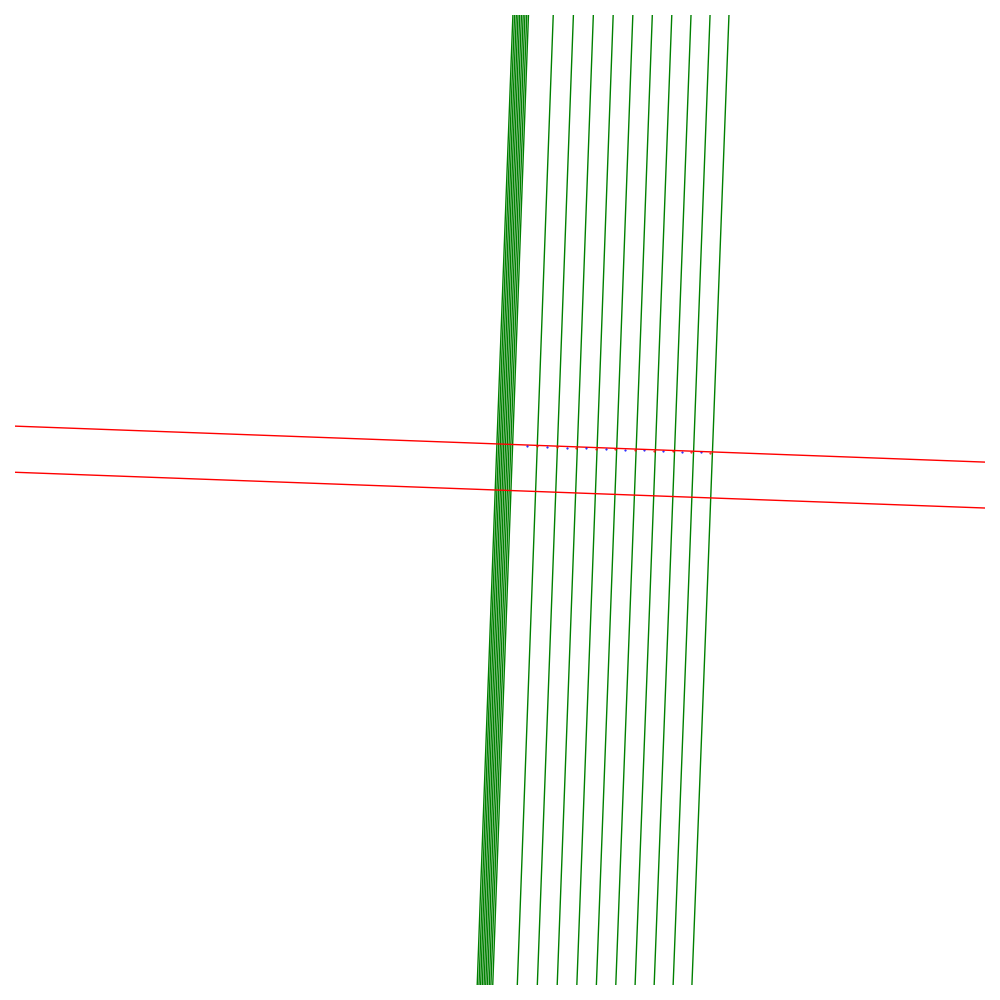

In [16]:
%matplotlib notebook
import plots

plot = plots.SpherePlot(radius=1)

plot.plot_great_circle(symetry_axis[0][0], 1, fill=False, edgecolor='r')

n_head = 10
for index, row in df.head(n_head).iterrows():      
    plot.set_color('b')    
    plot.plot_point_carthesian(row.x, row.y, row.z)    
    
for index, row in df.head(n_head).iterrows():      
    plot.set_color('r')
    plot.plot_point_carthesian(row.x_next, row.y_next, row.z_next)    
    
for i in range(0, n_head):    
    plot.plot_great_circle(base_axis[i][n], 1, fill=False, edgecolor='green')


#plot.make_sphere(wire=True, only_north=False, zoom=1)


plot.set_view(elevation=40, azimuth=220)
plot.ax.dist=7
plot.ax.axis('off')

plot.zoom_to(41.3, -144.4, 0.01, set_azimuth=True)

plot.show()